<a href="https://colab.research.google.com/github/Yahred/evolutionary-computation/blob/main/CGAOptimizationProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolución de un problema de optimización a través de un algoritmo genético

**Enunciado del problema**

La	siguiente	gráfica	corresponde	al	distribución	de	una	carpintería	local	que	se
encarga	el	proceso	de	elaboración	de	una	silla.

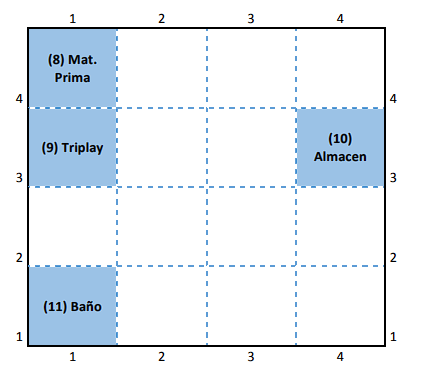

El	problema	es	que	la	carpintería	no	sabe	donde	ubicar	las	distintas	maquinas	de
trabajo	en	el	espacio	descrito.	La	maquinaria	para	realizar	el	proceso	de
elaboración	de	la	silla	es	el	siguiente

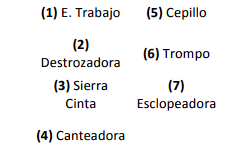

Cada	maquinaria	puede	ser	ubicada	en	los	espacios	de	2	x	2	y	en	los	espacios	en
blanco	descritos	en	la	grafica	anterior.		Los	espacios	descritos	en	color	azul	son
espacios	fijos	y	no	pueden	moverse	de	su	lugar

Y	el	recorrido	para	realizar	la	tarea	es	el	siguiente:

* 1 al 8
* 8 al 1
* 1 al 4
* 4 al 5
* 5 al 3
* 3 al 4
* 4 al 3
* 3 al 1
* 1 al 9
* 9 al 1
* 1 al 3
* 3 al 1
* 1 al 10

Encuentra	la	configuración	de	la	carpintería	que	minimice	el	recorrido	del
personal

# Setup del notebook

Bloque de código para importar los módulos necesarios

In [33]:
 pip install deap

In [34]:
from deap import base, creator, tools, algorithms

import numpy as np
import matplotlib.pyplot as plt

import math
import random

# Configuración de la evolución

A continuación se define la función de aptitud



In [35]:
class Estacion:
  def __init__(self, id: int, nombre: str, x: int, y: int) -> None:
    self.id = id
    self.nombre = nombre
    self.x = x
    self.y = y

  def __str__(self) -> str:
    return 'id: {} {} x: {}, y: {}'.format(self.id, self.nombre, self.x, self.y)

estaciones_nombres = {
   1: 'E. Trabajo',
   2: 'Destrozadora',
   3: 'Sierra cinta',
   4: 'Canteadora',
   5: 'Cepillo',
   6: 'Trompo',
   7: 'Esclopeadora',
}

estaciones_iniciales = {
    8: Estacion(8, 'Mat.Prima', 1, 4),
    9: Estacion(9, 'Triplay', 1, 3),
    10: Estacion(10, 'Almacen', 4, 3),
    11: Estacion(11, 'Baño', 1, 1),
}

posiciones_ocupadas = {
    '1,1': True,
    '1,3': True,
    '1,4': True,
    '4,3': True,
}

fenotipo = {
    0: (1, 2),
    1: (2, 1),
    2: (2, 2),
    3: (2, 3),
    4: (2, 4),
    5: (3, 1),
    6: (3, 2),
    7: (3, 3),
    8: (3, 4),
    9: (4, 1),
    10: (4, 2),
    11: (4, 4),
}

genes = 7

ruta = [1, 8, 1, 4, 5, 3, 4, 3, 1, 9, 1, 3, 1, 10]

Definimos una función para calcular la distancia entre dos estaciones

In [36]:
def calcular_distancia(a: Estacion, b: Estacion) -> int:
  return math.sqrt(math.pow(b.x - a.x, 2) + math.pow(b.y - a.y, 2)) * 2

Definimos una función para calcular la distancia acumalada en el recorrido

In [37]:
def calcular_recorrido(ruta: list[int], estaciones: dict[Estacion], verbose = False):
  acc = 0
  for i in range(1, len(ruta)):
    a = ruta[i - 1]
    b = ruta[i]
    estacion_a = estaciones[a]
    estacion_b = estaciones[b]
    distancia = calcular_distancia(estacion_a, estacion_b)
    if verbose:
      print(f'({estacion_a.id}) {estacion_a.nombre} ({estacion_b.id}) {estacion_b.nombre} Distancia: {distancia}')
    acc += distancia
  return acc

Definimos una función para decodificar el cromosoma del individuo

In [38]:
def decode_ind(ind: list[int]) -> list[Estacion]:
  posiciones = [fenotipo[gen] for gen in ind]
  estaciones = estaciones_iniciales.copy()
  for i in range(len(posiciones)):
    x, y = posiciones[i]
    estacion = Estacion(i + 1, estaciones_nombres[i + 1], x, y)
    estaciones[i + 1] = estacion
  return estaciones

Ahora se define la función fitness

In [39]:
def fitness(ind: list[int]):
  estaciones = decode_ind(ind)
  recorrido = calcular_recorrido(ruta, estaciones)
  return recorrido,

# Configuración de los individuos

El individuo estará compuesto por números entre el 0 y el 11 (inclusivo) en el que cada gen representa una de las 11 posibles posiciones que puede tomar la estación en la posición i del cromosoma

In [40]:
def crear_individuo():
  ind = list(range(len(fenotipo)))
  random.shuffle(ind)
  return ind[0: genes]

Se define una operación de cruza personalizada que asegure que no habrá repeticiones en los genes del cromosoma del individuo

In [41]:
def cruza(a, b):
    base = []
    for (a_gen, b_gen) in zip(a, b):
      if a_gen == b_gen:
        base.append(a_gen)
        continue

      base.append(None)

    offspring = [toolbox.clone(ind) for ind in (a, b)]
    for child in offspring:
      for (index, gen) in enumerate(base):
        if gen:
          child[index] = gen
          continue

        selection = None
        while selection is None or selection in child:
          selection = random.randint(0, len(fenotipo) - 1)

        child[index] = selection
        del child.fitness.values

    return offspring

Se definen los parametros de DEAP

In [42]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", cruza)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=5)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [43]:
ind = toolbox.individual()
ind

[2, 5, 3, 9, 1, 11, 7]

# Evolución

In [44]:
random.seed(64)
n_gen = 50
initial_pop = 100

pop = toolbox.population(n=initial_pop)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=n_gen, halloffame=hof, verbose=True, stats=stats)

ganador = tools.selBest(pop, k=1)[0]

gen	nevals	avg    
0  	100   	56.0786
1  	52    	48.699 
2  	56    	46.9105
3  	48    	39.2143
4  	51    	34.0933
5  	47    	32.8232
6  	53    	32.5477
7  	58    	32.6336
8  	57    	32.9272
9  	53    	32.7279
10 	70    	32.9038
11 	41    	32.972 
12 	53    	32.8785
13 	53    	33.0849
14 	62    	32.6557
15 	52    	32.3681
16 	62    	32.0828
17 	38    	32.0309
18 	62    	31.9667
19 	62    	32.4489
20 	54    	31.8448
21 	53    	31.6637
22 	52    	32.4804
23 	52    	32.2154
24 	63    	32.5185
25 	48    	31.5869
26 	55    	31.7672
27 	60    	31.9747
28 	48    	31.8802
29 	52    	31.9284
30 	51    	31.9004
31 	58    	31.6052
32 	49    	31.5812
33 	39    	31.4844
34 	51    	31.5211
35 	57    	31.6042
36 	58    	31.5322
37 	57    	31.4915
38 	63    	31.9176
39 	64    	31.9106
40 	62    	32.0274
41 	48    	31.6991
42 	67    	31.975 
43 	57    	31.6866
44 	42    	31.7599
45 	55    	31.4314
46 	51    	31.5485
47 	54    	32.6343
48 	48    	31.484 
49 	56    	31.7667
50 	54    	31.9788


In [45]:
ganador

[3, 11, 2, 6, 5, 0, 9]

# Resultados

A continuación se desplega una gráfica del acomodo optimo según el individuo ganador

Definimos una función para graficar la configuración del almacen

In [46]:
def graficar_estaciones(estaciones: list[Estacion]):
  fig, ax = plt.subplots()
  for i in range(5):
      ax.axhline(y=i, color='k', linewidth=2)
      ax.axvline(x=i, color='k', linewidth=2)

  ax.set_xticks([])
  ax.set_yticks([])

  ax.set_aspect('equal')

  padding = 0.5
  for estacion in estaciones.values():
    ax.text(estacion.x - 1 + padding, estacion.y - 1 + padding + 0.2, '({})'.format(estacion.id), ha='center', va='center', fontsize=8)

    if estacion.id in estaciones_iniciales:
      ax.text(estacion.x - 1 + padding, estacion.y - 1 + padding, estacion.nombre, ha='center', va='center', fontsize=8, color='green')
      continue

    ax.text(estacion.x - 1 + padding, estacion.y - 1 + padding, estacion.nombre, ha='center', va='center', fontsize=8)

  plt.show()

Graficamos el resultado

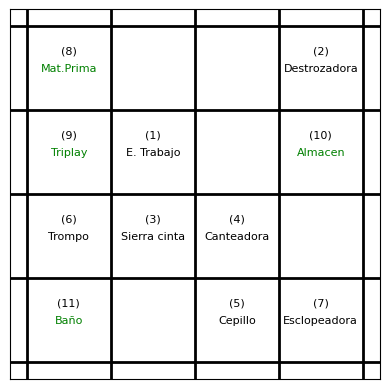

In [47]:
estaciones = decode_ind(ganador)
graficar_estaciones(estaciones)

In [58]:
calcular_recorrido(ruta, estaciones, verbose=True)

(1) E. Trabajo (8) Mat.Prima Distancia: 2.8284271247461903
(8) Mat.Prima (1) E. Trabajo Distancia: 2.8284271247461903
(1) E. Trabajo (4) Canteadora Distancia: 2.8284271247461903
(4) Canteadora (5) Cepillo Distancia: 2.0
(5) Cepillo (3) Sierra cinta Distancia: 2.8284271247461903
(3) Sierra cinta (4) Canteadora Distancia: 2.0
(4) Canteadora (3) Sierra cinta Distancia: 2.0
(3) Sierra cinta (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (9) Triplay Distancia: 2.0
(9) Triplay (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (3) Sierra cinta Distancia: 2.0
(3) Sierra cinta (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (10) Almacen Distancia: 4.0


31.31370849898476

# CGA

Está sección del notebook estará dedicada a cubrir la resolución del problema mediante el uso de CGA.

A continuación se carga una implementeción del algoritmo genético compacto escrita por mí basada en el trabajo de Harik at. el.

In [48]:
import random

class Individual:
    def __init__(self, chrom: list[int]) -> None:
        self.chrom = chrom
        self.fitness = None

    def __str__(self) -> str:
        return '{} Fitness: {}'.format(self.chrom, self.fitness)


def initialize_probs(num_genes: int) -> list[float]:
    return [0.5 for _ in range(num_genes)]


def create_individual(probs: list[float]):
    chrom = ['1' if random.uniform(0, 1) < prob else '0' for prob in probs]
    return Individual(''.join(chrom))


def compete(a: Individual, b: Individual, fitness: callable, fitness_min: bool):
    a.fitness = fitness(a.chrom)
    b.fitness = fitness(b.chrom)

    if a.fitness < b.fitness and fitness_min:
        return a, b

    if a.fitness > b.fitness and not fitness_min:
        return a, b

    return b, a


def adjust_probs(probs: list[float], winner: Individual, loser: Individual, generations: int):
    new_probs = []

    for i in range(len(probs)):
        loser_gen = loser.chrom[i]
        winner_gen = winner.chrom[i]

        if winner_gen == loser_gen:
            new_probs.append(probs[i])
            continue

        if winner_gen == '0':
            new_probs.append(probs[i] - 1/generations)
            continue

        new_probs.append(probs[i] + 1/generations)
    return new_probs


def has_converged(probs: list[float], convergence_criteria: float):
    for prob in probs:
        diff = 1 - prob
        if diff > convergence_criteria:
            return False
    return True


def evolve(fitness: callable, num_genes: int, generations: int, convergence_criteria=0.001, fitness_min=False):
    best = None
    probs = initialize_probs(num_genes)

    for _ in range(generations):
        a = create_individual(probs)
        b = create_individual(probs)

        winner, loser = compete(a, b, fitness, fitness_min)

        if not best:
            best = winner
        elif winner.fitness > best.fitness and not fitness_min:
            best = winner
        elif winner.fitness < best.fitness and fitness_min:
            best = winner

        probs = adjust_probs(probs, winner, loser, generations)

        if has_converged(probs, convergence_criteria):
            break

    return best.chrom, best.fitness

# Definición de la función de evaluación

Al individuo será un vector binario que representerá una secuencia de las posiciones de cada estación.

Antes definimos un diccionario que mapeará las posiciones disponibles para cada estación:

In [49]:
posiciones_compacto = [
    (1, 2),
    (2, 1),
    (2, 2),
    (2, 3),
    (2, 4),
    (3, 1),
    (3, 2),
    (3, 3),
    (3, 4),
    (4, 1),
    (4, 2),
    (4, 4),
]

estaciones_compacto = [
   None,
   { 'id': 1, 'nombre': 'E. Trabajo' },
   { 'id': 2, 'nombre': 'Destrozadora' },
   { 'id': 3, 'nombre': 'Sierra cinta' },
   { 'id': 4, 'nombre': 'Canteadora' },
   { 'id': 5, 'nombre': 'Cepillo' },
   { 'id': 6, 'nombre': 'Trompo' },
   { 'id': 7, 'nombre': 'Esclopeadora' },
   None,
   None,
   None,
   None,
]

Nuestro individuo estará compuesto por grupos de bits de tamaño suficiente para represanta el numéro de opciones disponibles a selección dentro de nuestra lista de estaciones.

Definimos una función para decodificar el binario y que nos retorne la lista de estaciones

In [50]:
def decode_bin(bin: str) -> dict[Estacion]:
  estaciones_disponibles = estaciones_compacto.copy()
  bin_restante = bin

  estaciones_seleccionadas = estaciones_iniciales.copy()
  for i in range(len(posiciones_compacto)):
      n_bits = math.ceil(math.log(len(estaciones_disponibles), 2))
      segmento_bin = bin_restante[:n_bits]
      bin_restante = bin_restante[n_bits:]

      if not segmento_bin:
          seleccion = 0
      else:
          seleccion = int(segmento_bin, 2)

      if seleccion >= len(estaciones_disponibles):
        seleccion = len(estaciones_disponibles) - 1

      estacion_seleccionada = estaciones_disponibles.pop(seleccion)

      if not estacion_seleccionada:
          continue

      x, y = posiciones_compacto[i]
      estacion_id = estacion_seleccionada['id']
      estaciones_seleccionadas[estacion_id] = Estacion(estacion_id, estacion_seleccionada['nombre'], x, y)

  return estaciones_seleccionadas


Ahora definimos una función fitness

In [51]:
def fitness_compact(bin: str):
  estaciones_seleccionadas = decode_bin(bin)
  recorrido = calcular_recorrido(ruta, estaciones_seleccionadas)
  return recorrido

Ahora llevamos a cabo la evolución

In [52]:
num_genes = 31
generations = 1000

best, distancia = evolve(fitness_compact, num_genes, generations, fitness_min=True)

Desplegamos el individuo ganador

In [53]:
best

'0110100000100010001100010001110'

In [54]:
distancia

31.785844453984343

Lo decodificamos

In [55]:
estaciones_ganadoras_compacto = decode_bin(best)

Graficamos el resultado

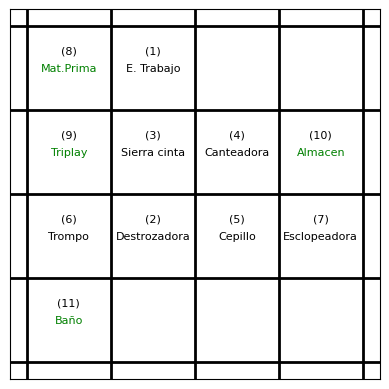

In [56]:
graficar_estaciones(estaciones_ganadoras_compacto)

In [57]:
calcular_recorrido(ruta, estaciones_ganadoras_compacto, verbose=True)

(1) E. Trabajo (8) Mat.Prima Distancia: 2.0
(8) Mat.Prima (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (4) Canteadora Distancia: 2.8284271247461903
(4) Canteadora (5) Cepillo Distancia: 2.0
(5) Cepillo (3) Sierra cinta Distancia: 2.8284271247461903
(3) Sierra cinta (4) Canteadora Distancia: 2.0
(4) Canteadora (3) Sierra cinta Distancia: 2.0
(3) Sierra cinta (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (9) Triplay Distancia: 2.8284271247461903
(9) Triplay (1) E. Trabajo Distancia: 2.8284271247461903
(1) E. Trabajo (3) Sierra cinta Distancia: 2.0
(3) Sierra cinta (1) E. Trabajo Distancia: 2.0
(1) E. Trabajo (10) Almacen Distancia: 4.47213595499958


31.785844453984343